In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib
from simple_dispatch import bidStack
import warnings
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)
colorset = ['#882255','#88CCEE','#332288', '#DDCC77',   '#CC6677','#44AA99', '#117733','#AA4499','#999933']
gds = {}
gds[2019] = pickle.load(open('Data/generator_data_short_WECC_2019.obj', 'rb'))
gds[2020] = pickle.load(open('Data/generator_data_short_WECC_2020.obj', 'rb'))

# Figure 1a: Bid Stack with Renewables

In [11]:
def plotBidStackRenewables(self, df_column, ax=None, xlim=86, save_str=None, show_legend=True, show_fig=True, xlab=False, plot_date = datetime.datetime(2020, 1, 1, 0,0), all_generation=None, fig=None):    
    
    # adapted from Thomas Deetjen's code : https://github.com/tdeetjen/simple_dispatch
    
    bs_df_fuel_color = self.df.copy()
    
    # Add column "fuel_color" to dataframe based on fuel type for each generator
    legend_mapping = {'sub_st':'Subbituminous Coal', 'ng_ct':'Natural Gas Combined Cycle', 
                      'ng_gt':'Natural Gas Combustion Turbine', 'ng_st':'Natural Gas Boiler', 
                      'rc_st':'Refined Coal', 'bit_st':'Bituminous Coal', '_':'Other'}
   
    c = {'ng': {'cc': colorset[0], 'ct': colorset[1], 'gt': colorset[2], 'st': colorset[3]}, 'sub': {'st': colorset[4]}, 'lig': {'st': str(colorset[5])}, 'bit': {'st': colorset[6]}, 'rc': {'st':  colorset[7]}}
    bs_df_fuel_color['fuel_color'] = '#bcbddc'
    for c_key in c.keys():
        for p_key in c[c_key].keys():
            bs_df_fuel_color.loc[(bs_df_fuel_color.fuel == c_key) & (bs_df_fuel_color.prime_mover == p_key), 'fuel_color'] = c[c_key][p_key]
        empty_color = '#dd1c77'
        color_2 = bs_df_fuel_color.fuel_color.replace('', empty_color)
        
    # prepare y depending on whether plotting cost or emissions
    y_data_e = self.df.gen_cost * 0
    if df_column == 'gen_cost':
        y_lab = 'Generation Cost [$/MWh]'
        y_data = self.df[df_column] - (self.df.co2_cost + self.df.so2_cost + self.df.nox_cost) #cost excluding emissions taxes
    if df_column == 'co2':
        y_lab = 'CO$_2$ Emissions [kg/MWh]'
        y_data = self.df[df_column + str(self.time)]

    #prepare and plot brackets for renewables
    
    dayofweek= plot_date.isocalendar()[2]
    week = plot_date.isocalendar()[1]
    hour = plot_date.hour
    plot_hour = week*7*24+dayofweek*24+hour
    total_renewables = all_generation.WECC_notcombustion[plot_hour]/1000
    solar=all_generation.WECC_SUN[plot_hour]/1000
    wind=all_generation.WECC_WND[plot_hour]/1000
    nuc=all_generation.WECC_NUC[plot_hour]/1000
    hydro=all_generation.WECC_WAT[plot_hour]/1000
    renewables_stack = np.array([solar,solar+wind, solar+wind+hydro, solar+wind+hydro+nuc])
    

    # plot
    if ax is None:
        f, ax = matplotlib.pyplot.subplots(figsize=(4, 4))
    # Bar chart: width of each is the capacity. Shift position by one index so that the bar lines up to the left of its capacity. E.g. if the first one has capacity 10, the bar goes from 0 to 10 and the following bar starts from 10. 
    ax.bar((self.df['mw' + str(self.time)].cumsum()[:-1])/1000  +total_renewables, height=y_data.values[1:], width=(self.df['mw' + str(self.time)].values[1:])/1000, color=color_2.values[1:], align='edge')
    if show_legend:
        color_legend = []
        for c in bs_df_fuel_color.fuel_color.unique(): #['#e41a1c', '#ff7f00', '#252525', '#377eb8', '#4daf4a', '#984ea3', '#bcbddc']::
            color_legend.append(matplotlib.patches.Patch(color=c, label=legend_mapping[bs_df_fuel_color.fuel[bs_df_fuel_color.fuel_color==c].iloc[0] + '_' + bs_df_fuel_color.prime_mover[bs_df_fuel_color.fuel_color==c].iloc[0]]))
        ax.legend(handles=color_legend, loc='upper left', ncol=2, fontsize=17)
    xlim=(self.df['mw' + str(self.time)].cumsum()[len(self.df['mw' + str(self.time)])-2])/1000 + total_renewables
    
    ax.set_xlim(0, xlim)
    if df_column == 'gen_cost':
        ax.set_ylim(0, 90)
        ax.set_yticks((0, 15, 30, 45, 60, 75, 90, 105))
        ax.set_yticklabels((0, 15, 30, 45, 60, 75, 90, 105), fontsize=14)
        ax.set_yticklabels((0, 15, 30, 45, 60, 75, 90, 105), fontsize=20)
    elif df_column == 'co2':
        ax.set_ylim(0, 1400)
        ax.set_yticks((250, 500, 750, 1000, 1250))
        ax.set_yticklabels((250, 500, 750, 1000, 1250), fontsize=14)
        ax.set_yticklabels((250, 500, 750, 1000, 1250), fontsize=20)
    if xlab:
        ax.set_xlabel('Generation Capacity [GW]', fontsize=22)
        plt.tick_params(labelsize=20)
    else:
        ax.set_xticklabels([])
    ax.set_ylabel(y_lab, fontsize=14)
    ax.set_ylabel(y_lab, fontsize=20)
    ymax=ax.get_ylim()[1]


    #draw braces
    curlyBrace(fig, ax, [0,0], [solar,0], k_r=.5/solar, bool_auto=True, str_text='', int_line_num=2, fontdict={},color = 'gold')
    curlyBrace(fig, ax, [renewables_stack[0],0], [renewables_stack[1],0], k_r=.5/wind, bool_auto=True, str_text='', int_line_num=2, fontdict={},color = 'tab:green')
    curlyBrace(fig, ax, [renewables_stack[1],0], [renewables_stack[2],0], k_r=.5/hydro, bool_auto=True, str_text='', int_line_num=2, fontdict={},color = 'tab:blue')
    curlyBrace(fig, ax, [renewables_stack[2],0], [renewables_stack[3],0], k_r=.5/nuc, bool_auto=True, str_text='', int_line_num=2, fontdict={},color = colorset[0])

    ax.annotate('Solar', xy=(solar/2, ymax/15), xytext=(solar/2, ymax/10), xycoords='data', rotation=90,
            fontsize=19, ha='center', va='bottom')

    ax.annotate('Wind', xy=(renewables_stack[0]+wind/2, ymax/15), xytext=(renewables_stack[0]+wind/2, ymax/10), xycoords='data', rotation=90,
        fontsize=19, ha='center', va='bottom')

    ax.annotate('Hydro', xy=(renewables_stack[1]+hydro/2, ymax/15), xytext=(renewables_stack[1]+hydro/2, ymax/10), xycoords='data', rotation=90,
        fontsize=19, ha='center', va='bottom')
    
    ax.annotate('Nuclear', xy=(renewables_stack[2]+nuc/2, ymax/15), xytext=(renewables_stack[2]+nuc/2, ymax/10), xycoords='data', rotation=90,
        fontsize=19, ha='center', va='bottom')
   
    ax.set_axisbelow(True)        
    ax.grid()

    plt.tight_layout()
    if save_str is not None:
        plt.savefig(save_str, bbox_inches='tight')
    if show_fig:
        plt.show()
        
    
    return ax

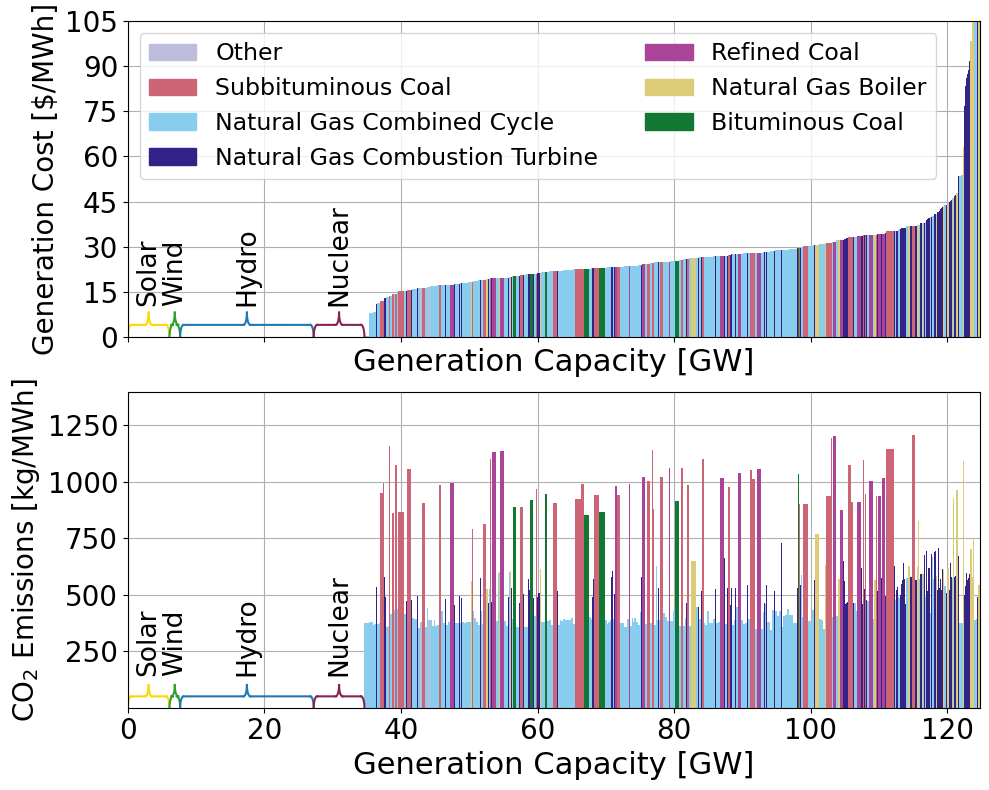

In [12]:
year =2020
all_generation = pd.read_csv('Data/region_eia_generation_data_'+str(year)+'.csv', index_col=0)
f, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)
plot_date = datetime.datetime(2020, 1, 10, 12, 0)
week=plot_date.isocalendar()[1]
bs = bidStack(gds[year], co2_dol_per_kg=0, time=week, dropNucHydroGeo=False, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
axes[0] = plotBidStackRenewables(bs, 'gen_cost', ax=axes[0], show_legend=True, show_fig=False, xlab=True, xlim=None, plot_date=plot_date, all_generation=all_generation, fig=f)
axes[1] = plotBidStackRenewables(bs, 'co2', ax=axes[1], show_legend=False, show_fig=False, xlim=None, xlab=True, plot_date=plot_date, all_generation=all_generation, fig =f,
                                  save_str='Merit_Order/1a_merit_order.pdf')


In [5]:
'''
Module Name : curlyBrace
Author : 高斯羽 博士 (Dr. GAO, Siyu)
Version : 1.0.2
Last Modified : 2019-04-22
This module is basically an Python implementation of the function written Pål Næverlid Sævik
for MATLAB (link in Reference).
The function "curlyBrace" allows you to plot an optionally annotated curly bracket between 
two points when using matplotlib.
The usual settings for line and fonts in matplotlib also apply.
The function takes the axes scales into account automatically. But when the axes aspect is 
set to "equal", the auto switch should be turned off.
Change Log
----------------------
* **Notable changes:**
    + Version : 1.0.2
        - Added considerations for different scaled axes and log scale
    + Version : 1.0.1
        - First version.
Reference
----------------------
https://uk.mathworks.com/matlabcentral/fileexchange/38716-curly-brace-annotation
List of functions
----------------------
* getAxSize_
* curlyBrace_
'''

import matplotlib.pyplot as plt
import numpy as np

def getAxSize(fig, ax):
    '''
    .. _getAxSize :
    Get the axes size in pixels.
    Parameters
    ----------
    fig : matplotlib figure object
        The of the target axes.
    ax : matplotlib axes object
        The target axes.
    Returns
    -------
    ax_width : float
        The axes width in pixels.
    ax_height : float
        The axes height in pixels.
    Reference
    -----------
    https://stackoverflow.com/questions/19306510/determine-matplotlib-axis-size-in-pixels
    '''

    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width, bbox.height
    ax_width *= fig.dpi
    ax_height *= fig.dpi

    return ax_width, ax_height

def curlyBrace(fig, ax, p1, p2, k_r=0.1, bool_auto=True, str_text='', int_line_num=2, fontdict={}, **kwargs):
# def curlyBrace(fig, ax, p1, p2, k_r=0.1, bool_auto=True, str_text='', int_line_num=2, fontdict={}, **kwargs):
    '''
    .. _curlyBrace :
    Plot an optionally annotated curly bracket on the given axes of the given figure.
    Note that the brackets are anti-clockwise by default. To reverse the text position, swap
    "p1" and "p2".
    Note that, when the axes aspect is not set to "equal", the axes coordinates need to be
    transformed to screen coordinates, otherwise the arcs may not be seeable. 
    Parameters
    ----------
    fig : matplotlib figure object
        The of the target axes.
    ax : matplotlib axes object
        The target axes.
    p1 : two element numeric list
        The coordinates of the starting point.
    p2 : two element numeric list
        The coordinates of the end point.
    k_r : float
        This is the gain controlling how "curvy" and "pointy" (height) the bracket is.
        Note that, if this gain is too big, the bracket would be very strange.
    bool_auto : boolean
        This is a switch controlling wether to use the auto calculation of axes
        scales.
        When the two axes do not have the same aspects, i.e., not "equal" scales,
        this should be turned on, i.e., True.
        When "equal" aspect is used, this should be turned off, i.e., False.
        If you do not set this to False when setting the axes aspect to "equal",
        the bracket will be in funny shape.
        Default = True
    str_text : string
        The annotation text of the bracket. It would displayed at the mid point
        of bracket with the same rotation as the bracket.
        By default, it follows the anti-clockwise convention. To flip it, swap 
        the end point and the starting point.
        The appearance of this string can be set by using "fontdict", which follows
        the same syntax as the normal matplotlib syntax for font dictionary.
        Default = empty string (no annotation)
    int_line_num : int
        This argument determines how many lines the string annotation is from the summit
        of the bracket.
        The distance would be affected by the font size, since it basically just a number of
        lines appended to the given string.
        Default = 2
    fontdict : dictionary
        This is font dictionary setting the string annotation. It is the same as normal
        matplotlib font dictionary.
        Default = empty dict
    **kwargs : matplotlib line setting arguments
        This allows the user to set the line arguments using named arguments that are
        the same as in matplotlib.
    Returns
    -------
    theta : float
        The bracket angle in radians.
    summit : list
        The positions of the bracket summit.
    arc1 : list of lists
        arc1 positions.
    arc2 : list of lists
        arc2 positions.
    arc3 : list of lists
        arc3 positions.
    arc4 : list of lists
        arc4 positions.
    Reference
    ----------
    https://uk.mathworks.com/matlabcentral/fileexchange/38716-curly-brace-annotation
    '''
    scale=3.5
    pt1 = [None, None]
    pt2 = [None, None]

    ax_width, ax_height = getAxSize(fig, ax)

    ax_xlim = list(ax.get_xlim())
    ax_ylim = list(ax.get_ylim())

    # log scale consideration
    if 'log' in ax.get_xaxis().get_scale():

        if p1[0] > 0.0:

            pt1[0] = np.log(p1[0])

        elif p1[0] < 0.0:

            pt1[0] = -np.log(abs(p1[0]))

        else:
            pt1[0] = 0.0

        if p2[0] > 0.0:
            pt2[0] = np.log(p2[0])
        elif p2[0] < 0.0:
            pt2[0] = -np.log(abs(p2[0]))
        else:
            pt2[0] = 0
        for i in range(0, len(ax_xlim)):

            if ax_xlim[i] > 0.0:

                ax_xlim[i] = np.log(ax_xlim[i])

            elif ax_xlim[i] < 0.0:

                ax_xlim[i] = -np.log(abs(ax_xlim[i]))

            else:

                ax_xlim[i] = 0.0

    else:

        pt1[0] = p1[0]
        pt2[0] = p2[0]

    if 'log' in ax.get_yaxis().get_scale():

        if p1[1] > 0.0:

            pt1[1] = np.log(p1[1])

        elif p1[1] < 0.0:

            pt1[1] = -np.log(abs(p1[1]))

        else:

            pt1[1] = 0.0

        if p2[1] > 0.0:

            pt2[1] = np.log(p2[1])

        elif p2[1] < 0.0:

            pt2[1] = -np.log(abs(p2[1]))

        else:

            pt2[1] = 0.0

        for i in range(0, len(ax_ylim)):

            if ax_ylim[i] > 0.0:

                ax_ylim[i] = np.log(ax_ylim[i])

            elif ax_ylim[i] < 0.0:

                ax_ylim[i] = -np.log(abs(ax_ylim[i]))

            else:

                ax_ylim[i] = 0.0

    else:

        pt1[1] = p1[1]
        pt2[1] = p2[1]

    # get the ratio of pixels/length
    xscale = ax_width / abs(ax_xlim[1] - ax_xlim[0])
    yscale = ax_height / abs(ax_ylim[1] - ax_ylim[0])

    # this is to deal with 'equal' axes aspects
    if bool_auto:

        pass

    else:

        xscale = 1.0
        yscale = 1.0

    # convert length to pixels, 
    # need to minus the lower limit to move the points back to the origin. Then add the limits back on end.
    pt1[0] = (pt1[0] - ax_xlim[0]) * xscale
    pt1[1] = (pt1[1] - ax_ylim[0]) * yscale
    pt2[0] = (pt2[0] - ax_xlim[0]) * xscale
    pt2[1] = (pt2[1] - ax_ylim[0]) * yscale

    # calculate the angle
    theta = np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0])

    # calculate the radius of the arcs
    r = np.hypot(pt2[0] - pt1[0], pt2[1] - pt1[1]) * k_r

    # arc1 centre
    x11 = pt1[0] + r * np.cos(theta)
    y11 = pt1[1] + r * np.sin(theta)

    # arc2 centre
    x22 = (pt2[0] + pt1[0]) / 2.0 - 2.0 * r * np.sin(theta) - r * np.cos(theta)
    y22 = (pt2[1] + pt1[1]) / 2.0 + 2.0 * r * np.cos(theta) - r * np.sin(theta)

    # arc3 centre
    x33 = (pt2[0] + pt1[0]) / 2.0 - 2.0 * r * np.sin(theta) + r * np.cos(theta)
    y33 = (pt2[1] + pt1[1]) / 2.0 + 2.0 * r * np.cos(theta) + r * np.sin(theta)

    # arc4 centre
    x44 = pt2[0] - r * np.cos(theta)
    y44 = pt2[1] - r * np.sin(theta)

    # prepare the rotated
    q = np.linspace(theta, theta + np.pi/2.0, 50)

    # reverse q
    # t = np.flip(q) # this command is not supported by lower version of numpy
    t = q[::-1]

    # arc coordinates
    arc1x = r * np.cos(t + np.pi/2.0) + x11
    arc1y = r * np.sin(t + np.pi/2.0) + y11

    arc2x = r * np.cos(q - np.pi/2.0) + x22
    arc2y = r * np.sin(q - np.pi/2.0) + y22

    arc3x = r * np.cos(q + np.pi) + x33
    arc3y = r * np.sin(q + np.pi) + y33

    arc4x = r * np.cos(t) + x44
    arc4y = r * np.sin(t) + y44

    # convert back to the axis coordinates
    arc1x = arc1x / xscale + ax_xlim[0]
    arc2x = arc2x / xscale + ax_xlim[0]
    arc3x = arc3x / xscale + ax_xlim[0]
    arc4x = arc4x / xscale + ax_xlim[0]

    arc1y = arc1y / yscale + ax_ylim[0]
    arc2y = arc2y / yscale + ax_ylim[0]
    arc3y = arc3y / yscale + ax_ylim[0]
    arc4y = arc4y / yscale + ax_ylim[0]

    # log scale consideration
    if 'log' in ax.get_xaxis().get_scale():

        for i in range(0, len(arc1x)):

            if arc1x[i] > 0.0:

                arc1x[i] = np.exp(arc1x[i])

            elif arc1x[i] < 0.0:

                arc1x[i] = -np.exp(abs(arc1x[i]))

            else:

                arc1x[i] = 0.0

        for i in range(0, len(arc2x)):

            if arc2x[i] > 0.0:

                arc2x[i] = np.exp(arc2x[i])

            elif arc2x[i] < 0.0:

                arc2x[i] = -np.exp(abs(arc2x[i]))

            else:

                arc2x[i] = 0.0

        for i in range(0, len(arc3x)):

            if arc3x[i] > 0.0:

                arc3x[i] = np.exp(arc3x[i])

            elif arc3x[i] < 0.0:

                arc3x[i] = -np.exp(abs(arc3x[i]))

            else:

                arc3x[i] = 0.0

        for i in range(0, len(arc4x)):

            if arc4x[i] > 0.0:

                arc4x[i] = np.exp(arc4x[i])

            elif arc4x[i] < 0.0:

                arc4x[i] = -np.exp(abs(arc4x[i]))

            else:

                arc4x[i] = 0.0

    else:

        pass

    if 'log' in ax.get_yaxis().get_scale():

        for i in range(0, len(arc1y)):

            if arc1y[i] > 0.0:

                arc1y[i] = np.exp(arc1y[i])

            elif arc1y[i] < 0.0:

                arc1y[i] = -np.exp(abs(arc1y[i]))

            else:

                arc1y[i] = 0.0

        for i in range(0, len(arc2y)):

            if arc2y[i] > 0.0:

                arc2y[i] = np.exp(arc2y[i])

            elif arc2y[i] < 0.0:

                arc2y[i] = -np.exp(abs(arc2y[i]))

            else:

                arc2y[i] = 0.0

        for i in range(0, len(arc3y)):

            if arc3y[i] > 0.0:

                arc3y[i] = np.exp(arc3y[i])

            elif arc3y[i] < 0.0:

                arc3y[i] = -np.exp(abs(arc3y[i]))

            else:

                arc3y[i] = 0.0

        for i in range(0, len(arc4y)):

            if arc4y[i] > 0.0:

                arc4y[i] = np.exp(arc4y[i])

            elif arc4y[i] < 0.0:

                arc4y[i] = -np.exp(abs(arc4y[i]))

            else:

                arc4y[i] = 0.0

    else:

        pass

    # plot arcs
    ax.plot(arc1x, arc1y*scale, **kwargs)
    ax.plot(arc2x, arc2y*scale, **kwargs)
    ax.plot(arc3x, arc3y*scale, **kwargs)
    ax.plot(arc4x, arc4y*scale, **kwargs)

    # plot lines
    ax.plot([arc1x[-1], arc2x[1]], np.multiply([arc1y[-1], arc2y[1]],scale), **kwargs)
    ax.plot([arc3x[-1], arc4x[1]], np.multiply([arc3y[-1], arc4y[1]],scale), **kwargs)

    summit = [arc2x[-1], arc2y[-1]]

    if str_text:

        int_line_num = int(int_line_num)

        str_temp = '\n' * int_line_num
        
        # convert radians to degree and within 0 to 360
        ang = np.degrees(theta) % 360.0

        if (ang >= 0.0) and (ang <= 90.0):

            rotation = ang

            str_text = str_text + str_temp

        if (ang > 90.0) and (ang < 270.0):

            rotation = ang + 180.0

            str_text = str_temp + str_text

        elif (ang >= 270.0) and (ang <= 360.0):

            rotation = ang

            str_text = str_text + str_temp

        else:

            rotation = ang

        ax.axes.text(arc2x[-1], arc2y[-1], str_text, ha='center', va='center', rotation=rotation, fontdict=fontdict)

    else:

        pass

    arc1 = [arc1x, arc1y]
    arc2 = [arc2x, arc2y]
    arc3 = [arc3x, arc3y]
    arc4 = [arc4x, arc4y]

    return theta, summit, arc1, arc2, arc3, arc4